## IMPORT PACKAGES

In [1]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
import pickle
import numpy as np

sys.path.append('../../')
from utils import microarray_utils, clustering_utils, bokeh_ui_utils, file_utils

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/env

In [2]:
full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')
full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})
full_filtered_norm_df = microarray_utils.normalize_expression_per_gene(full_filtered_df, z=True)

num_genes = full_filtered_df.shape[0]
num_genes

19965

In [3]:
veg_cols = [col for col in full_filtered_norm_df.columns if col[0] != 'C']
veg_filtered_df = full_filtered_df[veg_cols]
veg_filtered_norm_df = microarray_utils.normalize_expression_per_gene(veg_filtered_df, z=True)
veg_filtered_norm_df.head()

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,S3_GSM285562,S6_GSM285543,S6_GSM285556,S6_GSM285563,S9_GSM285544,S9_GSM285564,S15_GSM285559,S15_GSM285566,S24_GSM285547,S24_GSM285560
0,YF00000003.t1,0.520544,0.690252,0.719369,0.557258,0.688252,0.658956,0.466058,0.506407,0.660426,...,-0.156263,-0.137960,-0.273487,-0.428225,0.490302,0.308555,0.703729,0.656027,0.871373,0.738928
1,YF00000004.t1,0.989444,1.286975,1.243527,0.857797,1.234631,1.228344,0.112058,0.945264,0.945719,...,0.359729,-1.093115,-0.396154,-0.727802,0.404100,-0.236106,-0.708534,-0.444267,-1.381890,-1.344474
2,YF00000005.t1,1.113821,1.462633,1.457588,1.196341,1.211002,1.429006,0.938722,1.065184,1.100214,...,-1.077054,-1.181055,-0.854188,-0.945708,-0.875700,-0.791939,-0.652231,-0.842022,-0.666380,-0.323074
3,YF00000006.t1,-0.634456,-0.084362,-0.746828,-1.737025,-0.802695,-0.874601,-1.581689,-1.329785,-2.071800,...,0.180210,0.344729,0.928072,0.780125,0.559460,0.816101,1.026798,1.007873,0.963255,1.444624
4,YF00000012.t1,0.904525,1.275242,1.325920,1.164572,1.207677,1.313757,0.810241,1.245220,1.504221,...,-0.569400,-1.461859,-1.317767,-0.795824,-0.311699,-0.568329,-1.068558,-0.777503,-0.679354,-0.626649


In [4]:
np.min(veg_filtered_norm_df[veg_cols[1:]])

-4.2851660500299396

In [5]:
sex_cols = [col for col in full_filtered_norm_df.columns if col[0] == 'C']
sex_filtered_df = full_filtered_df[['TTHERM_ID'] + sex_cols]
sex_filtered_norm_df = microarray_utils.normalize_expression_per_gene(sex_filtered_df, z=True)
sex_filtered_norm_df.head()

,TTHERM_ID,C0_GSM285570,C0_GSM656230,C4_GSM285574,C4_GSM285588,C4_GSM656234,C6_GSM285575,C6_GSM656232,C8_GSM285576,C8_GSM285590,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,YF00000003.t1,1.922101,1.966545,-0.207719,-0.225718,-1.274308,0.670616,0.247564,0.083921,-0.309487,...,0.312067,-0.820669,-1.408347,-0.211730,0.470200,0.285100,-0.030541,1.178342,1.078771,0.848862
1,YF00000004.t1,0.928303,-0.344700,-0.132419,0.756841,-2.279815,-0.799257,-1.878331,0.421084,0.772646,...,-0.180477,0.494320,0.638636,-0.724238,0.587174,0.570119,-1.498112,0.555520,0.677594,-1.883279
2,YF00000005.t1,-0.012142,1.053603,1.961170,1.234671,1.450551,0.760182,0.955340,-0.895013,-0.018802,...,0.680054,-0.761484,-0.713878,-0.066159,-1.449942,-1.325012,-0.204164,-1.527723,-1.437644,-1.172546
3,YF00000006.t1,-0.289049,-0.087152,1.701945,1.452763,0.599894,1.423774,1.997772,0.088334,0.433074,...,-1.546722,0.568312,-0.164496,-1.343124,-0.030178,-0.683500,0.005971,-0.877114,-0.912154,-2.051801
4,YF00000012.t1,1.784321,2.364615,0.623806,0.716842,0.929095,-1.478288,-1.445646,-0.848881,-1.750716,...,0.156846,0.763776,0.498721,0.572109,-0.457177,-0.612148,-0.007730,-0.580322,-1.099495,-0.182838


In [6]:
np.max(sex_filtered_norm_df[sex_cols[1:]])

4.409173940613549

In [7]:
microarray_utils.get_arith_mean_expression(sex_filtered_norm_df)

,TTHERM_ID,C0,C4,C6,C8,C10,C12,C14,C16,C18
0,YF00000003.t1,1.944323,-0.569248,0.459090,-0.112783,-0.670065,-0.974458,-0.813582,0.241586,1.035325
1,YF00000004.t1,0.291801,-0.551798,-1.338794,0.596865,0.967333,0.401084,0.136239,-0.113607,-0.216722
2,YF00000005.t1,0.520730,1.548797,0.857761,-0.456907,0.615146,0.312900,-0.513840,-0.993039,-1.379304
3,YF00000006.t1,-0.188100,1.251534,1.710773,0.260704,0.197617,-0.742835,-0.313103,-0.235902,-1.280356
4,YF00000012.t1,2.074468,0.756581,-1.461967,-1.299799,-0.398859,0.335892,0.611535,-0.359018,-0.620885
...,...,...,...,...,...,...,...,...,...,...
19960,YF00038376.t1,0.608624,0.222924,1.184139,0.938137,-0.486282,-0.774615,-0.865527,-0.074882,-0.004314
19961,YF00038377.t1,0.211937,-0.537021,-0.191305,-0.033575,-1.818845,-0.786971,0.495428,0.876787,1.172969
19962,YF00038378.t1,-0.193687,2.145082,0.342682,-0.550428,-0.741528,-0.413482,-0.329094,-0.154288,-0.486245
19963,YF00038379.t1,1.131383,0.066749,-0.460377,0.144049,-1.300905,-1.264789,0.529683,0.960462,0.031795


In [8]:
# import numpy as np
# import scipy.stats as st

# def normalizer(array):
#     """
#     Normalizes the values of an array to range from zero to one
#     """
    
#     a = np.array(array)
    
#     normalized = (array - np.min(array)) / (np.max(array) - np.min(array))
    
#     return normalized


# def z_normalizer(array):

#     """
#     Normalizes the values of an array to z-score from mean
#     """

#     # log_a = [np.log10(expr) for expr in array]
#     normalized = pd.Series(st.zscore(array))
#     return normalized


# def normalize_expression_per_gene(expression_df, z=False):
#     """
#     Function to normalize all gene expression to range from zero to one.
#     """
#     if 'TTHERM_ID' in expression_df.columns:
#         ttids = expression_df['TTHERM_ID'].values
#         data = expression_df[list(expression_df.columns)[1:]]

#         columns = expression_df.columns.tolist()

#         if z:
#             norm_expression_df = data.apply(lambda row: z_normalizer(row), axis=1)
#             norm_expression_df.columns = columns[1:]
        
#         else:
#             norm_expression_df = data.apply(lambda row: normalizer(row), axis=1)
        
#         norm_expression_df['TTHERM_ID'] = ttids
#         # norm_expression_df.columns = columns
        
        
#         columns = norm_expression_df.columns.tolist()
        
#         rearrangment = columns[-1:] + columns[:-1]
        
#         norm_expression_df = norm_expression_df[rearrangment]
        
#     else:

#         if z:
#             norm_expression_df = data.apply(lambda row: z_normalizer(row), axis=1)
#             norm_expression_df.columns = columns

#         else:
#             norm_expression_df = expression_df.apply(lambda row: normalizer(row), axis=1)
    
#     return norm_expression_df

In [9]:
# expression_df = full_filtered_df
# data = expression_df[list(expression_df.columns)[1:]]
# ttids = expression_df['TTHERM_ID'].values
# columns = expression_df.columns.tolist()

In [10]:
# normalize_expression_per_gene(full_filtered_df, z=True)

In [11]:
# columns

In [12]:
# data.apply(lambda row: normalizer(row), axis=1)

In [13]:
# data.apply(lambda row: z_normalizer(row), axis=1)

In [14]:
# import numpy as np
# import scipy.stats as st

# def get_arith_mean_expression(expression_df):
#     """
#     Function to take an expression dataframe from the microarrays and collapse it into the means of
#     all replicate chips.
#     """
#     # C2 and S12 got removed during quality control
#     x = [
#         'Ll', 
#         'Lm', 
#         'Lh', 
#         'S0', 
#         'S3', 
#         'S6', 
#         'S9', 
#         # 'S12', 
#         'S15', 
#         'S24', 
#         'C0', 
#         # 'C2', 
#         'C4', 
#         'C6', 
#         'C8', 
#         'C10', 
#         'C12', 
#         'C14', 
#         'C16', 
#         'C18']
    
#     # cols = expression_df.columns[1:]
#     # x = [c for c in x if c in cols]
    
#     condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}
    
#     for c in list(expression_df.columns)[1:]:
        
#         cond = c.split('_')[0]
#         if cond in condition_expr_dict.keys():
#             expr_list = condition_expr_dict.get(cond, [])

#             # Need to avoid true zeros
#             expr_list.append(expression_df[c].values)
#             condition_expr_dict[cond] = expr_list
        
#     condition_mean_dict = {c: np.mean(np.array(condition_expr_dict[c]), axis=0) for c in condition_expr_dict.keys() if c in x}
    
#     mean_expr_df = pd.DataFrame(condition_mean_dict)
#     mean_expr_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
#     cols = list(mean_expr_df.columns)
#     reorder = cols[-1:] + cols[:-1]
#     mean_expr_df = mean_expr_df[reorder]
    
#     return mean_expr_df

# def get_geom_mean_expression(expression_df):
#     """
#     Function to take an expression dataframe from the microarrays and collapse it into the means of
#     all replicate chips.
#     """
#     # C2 and S12 got removed during quality control
#     x = [
#         'Ll', 
#         'Lm', 
#         'Lh', 
#         'S0', 
#         'S3', 
#         'S6', 
#         'S9', 
#         # 'S12', 
#         'S15', 
#         'S24', 
#         'C0', 
#         # 'C2', 
#         'C4', 
#         'C6', 
#         'C8', 
#         'C10', 
#         'C12', 
#         'C14', 
#         'C16', 
#         'C18']
    
#     # cols = expression_df.columns[1:]
#     # x = [c for c in x if c in cols]
    
#     condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}
    
#     for c in list(expression_df.columns)[1:]:
        
#         cond = c.split('_')[0]
#         if cond in condition_expr_dict.keys():
#             expr_list = condition_expr_dict.get(cond, [])

#             # Need to avoid true zeros
#             expr_list.append(expression_df[c].values)
#             condition_expr_dict[cond] = expr_list
        
#     condition_mean_dict = {c: (st.mstats.gmean(np.array(condition_expr_dict[c]) + 1, 0) - 1) for c in condition_expr_dict.keys() if c in x}
    
#     mean_expr_df = pd.DataFrame(condition_mean_dict)
#     mean_expr_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
#     cols = list(mean_expr_df.columns)
#     reorder = cols[-1:] + cols[:-1]
#     mean_expr_df = mean_expr_df[reorder]
    
#     return mean_expr_df

In [15]:
# expression_df = full_filtered_norm_df

# x = [
#     'Ll', 
#     'Lm', 
#     'Lh', 
#     'S0', 
#     'S3', 
#     'S6', 
#     'S9', 
#     # 'S12', 
#     'S15', 
#     'S24', 
#     'C0', 
#     # 'C2', 
#     'C4', 
#     'C6', 
#     'C8', 
#     'C10', 
#     'C12', 
#     'C14', 
#     'C16', 
#     'C18']

# condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}

# for c in list(expression_df.columns)[1:]:
    
#     cond = c.split('_')[0]
#     if cond in condition_expr_dict.keys():
#         expr_list = condition_expr_dict.get(cond, [])

#         # Need to avoid true zeros
#         expr_list.append(expression_df[c].values)
#         condition_expr_dict[cond] = expr_list
    
# condition_mean_dict = {c: np.mean(np.array(condition_expr_dict[c]), axis=0) for c in condition_expr_dict.keys() if c in x}

In [16]:
# condition_mean_dict

In [17]:
full_filtered_norm_df

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,YF00000003.t1,0.750669,0.967775,1.005024,0.797637,0.965217,0.927738,0.680966,0.732584,0.929619,...,0.088223,-0.552972,-0.885632,-0.208277,0.177735,0.072958,-0.105714,0.578584,0.522222,0.392080
1,YF00000004.t1,0.996141,1.316545,1.269757,0.854372,1.260177,1.253407,0.051301,0.948564,0.949053,...,-0.091352,0.520866,0.651799,-0.584686,0.605109,0.589635,-1.286793,0.576391,0.687144,-1.636241
2,YF00000005.t1,1.505324,1.936262,1.930029,1.607273,1.625385,1.894718,1.288998,1.445236,1.488513,...,0.303303,-0.625523,-0.594849,-0.177504,-1.069117,-0.988621,-0.266425,-1.119233,-1.061192,-0.890382
3,YF00000006.t1,-1.189556,-0.813291,-1.266419,-1.943716,-1.304632,-1.353816,-1.837466,-1.665163,-2.172704,...,-0.110671,1.118798,0.692817,0.007681,0.770896,0.391120,0.791909,0.278572,0.258203,-0.404272
4,YF00000012.t1,1.207863,1.647127,1.707176,1.515994,1.567069,1.692765,1.096146,1.611554,1.918446,...,-0.026861,0.418706,0.224121,0.277997,-0.477633,-0.591403,-0.147681,-0.568038,-0.949179,-0.276233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19960,YF00038376.t1,0.063061,-0.097070,-1.668731,-0.010066,0.603357,-0.791842,1.115550,-1.773387,-0.923099,...,-0.020961,-0.818870,-1.270693,0.132133,-0.574461,-1.236733,2.448661,0.519212,-1.371342,1.721203
19961,YF00038377.t1,-0.010397,1.580945,0.701271,0.536139,0.800949,0.621235,1.598993,1.586135,1.134164,...,-0.930126,0.754282,0.837825,-0.493351,1.093409,1.002212,0.176079,1.301999,1.910129,-0.029463
19962,YF00038378.t1,0.230899,0.512523,0.805244,0.903023,0.478683,0.191367,1.877399,-0.125535,-0.282245,...,-0.196564,-0.197864,-0.781782,-0.017249,-0.434331,-0.735290,0.800186,-0.910749,-1.537195,0.886959
19963,YF00038379.t1,-0.145796,0.643386,0.859557,-0.700658,0.887805,0.562234,-0.316155,0.492984,0.704152,...,-1.856860,0.289371,0.270703,-1.269912,0.154054,0.441321,-0.277849,-1.168070,0.301356,-1.030532


In [18]:
# get_arith_mean_expression(full_filtered_norm_df)

# LEIDEN CLUSTERING

In [19]:
phases_list = ['full', 'veg', 'sex']
phases = 'full'

In [20]:
metric = 'manhattan'
# metric='minkowski_3.0'

resolution_param=0.005
# resolution_param=0.0001

n_neighbors = 3

dataset = 'microarray'

In [21]:
# Moving normalization from within the function to before the function
leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
    full_filtered_norm_df,
    dataset,
    metric=metric,
    n_neighbors=n_neighbors, 
    resolution_param=resolution_param, 
    partition_type = 'EXP', 
    n_jobs = -1, 
    random_state=42
    )

In [22]:
full_filtered_norm_df.head()

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,YF00000003.t1,0.750669,0.967775,1.005024,0.797637,0.965217,0.927738,0.680966,0.732584,0.929619,...,0.088223,-0.552972,-0.885632,-0.208277,0.177735,0.072958,-0.105714,0.578584,0.522222,0.392080
1,YF00000004.t1,0.996141,1.316545,1.269757,0.854372,1.260177,1.253407,0.051301,0.948564,0.949053,...,-0.091352,0.520866,0.651799,-0.584686,0.605109,0.589635,-1.286793,0.576391,0.687144,-1.636241
2,YF00000005.t1,1.505324,1.936262,1.930029,1.607273,1.625385,1.894718,1.288998,1.445236,1.488513,...,0.303303,-0.625523,-0.594849,-0.177504,-1.069117,-0.988621,-0.266425,-1.119233,-1.061192,-0.890382
3,YF00000006.t1,-1.189556,-0.813291,-1.266419,-1.943716,-1.304632,-1.353816,-1.837466,-1.665163,-2.172704,...,-0.110671,1.118798,0.692817,0.007681,0.770896,0.391120,0.791909,0.278572,0.258203,-0.404272
4,YF00000012.t1,1.207863,1.647127,1.707176,1.515994,1.567069,1.692765,1.096146,1.611554,1.918446,...,-0.026861,0.418706,0.224121,0.277997,-0.477633,-0.591403,-0.147681,-0.568038,-0.949179,-0.276233


In [23]:
leiden_label_df_round_1_arranged = bokeh_ui_utils.arrange_modules(full_filtered_norm_df, leiden_label_df_round_1, phases) 
leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)
leiden_label_df_round_1_arranged_sorted.to_csv('./test_nn3_leiden_label_df_round_1.csv', index=False)

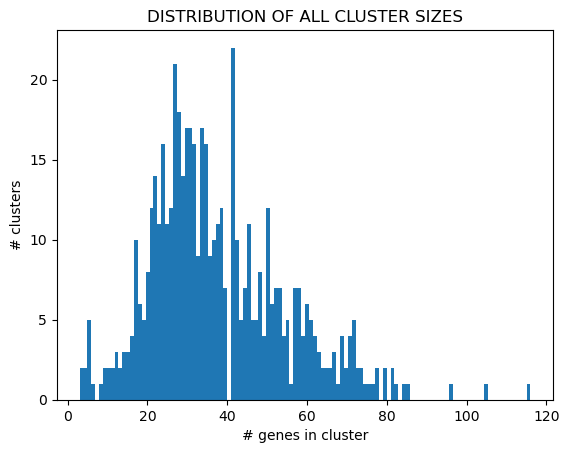

In [24]:
plt.hist(cluster_sizes, max(cluster_sizes))
plt.title('DISTRIBUTION OF ALL CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

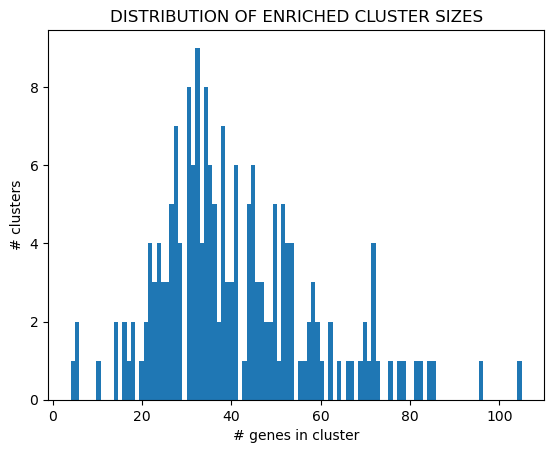

In [25]:
plt.hist(enriched_cluster_sizes, max(enriched_cluster_sizes))
plt.title('DISTRIBUTION OF ENRICHED CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

In [26]:
key_lens = [len(k) for k in partition_stats.keys()]
max_key_len = max(key_lens)

for k, v in partition_stats.items():
    print(f'{" " * (max_key_len - len(k))}{k}:', v)

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.030251047713623518
                  modularity: 0.7356341539936877
                   nclusters: 530
           mean_cluster_size: 37.66981132075472
         median_cluster_size: 34.0
             sd_cluster_size: 17.03011854627704
          nenriched_clusters: 188
  mean_enriched_cluster_size: 40.86702127659574
median_enriched_cluster_size: 37.0
    sd_enriched_cluster_size: 17.343168918870724
     nenriched_cluster_genes: 7683
                    datetime: 2024-05-15 12:29:13.077709


In [27]:
enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

In [28]:
outfile='../enrichment/test_nn3_full_enrichment.csv'
enrich_full_nn3.to_csv(outfile, index=False)

In [29]:
complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')

In [30]:
palette45 = """
#51635F\n#FF1C16\n#16FC26\n#403DFC\n#FE0DCE\n#F9AA00\n#00FFD5\n#22BFFE\n#BB3551\n#E6FE97\n#ECADFF\n#FFBFBD\n#CF00F5\n#0D8B00\n#D7FEFF\n#8D7200\n#F76C00\n#AD3288\n#5C5AB8\n#FC0080\n#B8FF16\n#00AAB4\n#FBE11C\n#9AAAD9\n#8BBB8C\n#934B47\n#6EFE99\n#9C6D91\n#FB9778\n#9D32AF\n#D40087\n#FFDC9D\n#FF8DB6\n#A96AFC\n#FDDDFB\n#168CF7\n#FD6CF9\n#F64553\n#4D6A00\n#FAFEDB\n#A7977D\n#0DFBFF\n#86B80D\n#FD8AE4\n#B7B126
""".split()

palette32 = """
white\n#F91622\n#16FC0D\n#5138FB\n#FD00CF\n#FDD51C\n#16FDD7\n#FC8B8E\n#16BFFF\n#DF9BFD\n#669C2A\n#FEE7C4\n#F31685\n#DF16FD\n#C1F1FE\n#A23D7E\n#D5FD0D\n#8C5A0D\n#FC790D\n#4F5CBC\n#FFCBEF\n#168D72\n#68FA93\n#C4FDC9\n#F7A449\n#16789B\n#AD0DAB\n#C4262E\n#0DF1FF\n#EFF994\n#B6C1FE\n#8F22CD
""".split()

palette35 = """
#585F6A\n#FE1626\n#00FB0D\n#2E40FC\n#FD0DCE\n#FCD200\n#F7868C\n#16FFDC\n#22BEFB\n#D28EF6\n#609000\n#FFE7C9\n#F51683\n#FF730D\n#CAFE16\n#AA3586\n#BEEEFD\n#BD00FA\n#895D22\n#FEC7F0\n#495AA1\n#73F995\n#229270\n#ED963B\n#F6FE97\n#C5FFD0\n#C50DC8\n#6993FF\n#C22A35\n#16ECFC\n#AA707E\n#7A3BCB\n#7C845C\n#358FAA\n#BDBAF6
""".split()

palette38 = """
#636265\n#F60D16\n#00F90D\n#3540FB\n#FD0DD0\n#FDDB0D\n#00FFE2\n#FA8884\n#2ABEFE\n#E5A3FF\n#518F00\n#FEFDD5\n#D51CFF\n#ED007F\n#A33879\n#96731C\n#C8FB16\n#C0ECFE\n#FBC1DA\n#5658BA\n#F96900\n#F69F1C\n#58FA9C\n#008E72\n#BA22B9\n#167D97\n#794D8A\n#CEFE9C\n#BB222E\n#954D45\n#00DCEF\n#FD66B0\n#B2FDD3\n#FDBD9F\n#A9B4F1\n#B371FE\n#849566\n#2A8EFF
""".split()

palette64 = """
white\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [31]:
palette36 = ["#FFFFFF", 
             "#E4E1E3", 
             "#F6222E", 
             "#FE00FA", 
             "#16FF32", 
             "#3283FE", 
             "#FEAF16", 
             "#B00068", 
             "#1CFFCE",
             "#90AD1C", 
             "#2ED9FF", 
             "#DEA0FD", 
             "#AA0DFE", 
             "#F8A19F", 
             "#325A9B", 
             "#C4451C", 
             "#1C8356", 
             "#85660D",
             "#B10DA1", 
             "#FBE426", 
             "#1CBE4F", 
             "#FA0087", 
             "#FC1CBF", 
             "#F7E1A0", 
             "#C075A6", 
             "#782AB6", 
             "#AAF400",
             "#BDCDFF", 
             "#822E1C", 
             "#B5EFB5", 
             "#7ED7D1", 
             "#1C7F93", 
             "#D85FF7", 
             "#683B79", 
             "#66B0FF", 
             "#3B00FB",
             "magenta"]

change index 5 to #778899. Change index 9 to #2F4F4F. Add #FF7F50. Change index 9 to #FFBCD9. Change index 14 to #DEA5A4

In [32]:
palette27 = ["#FFFFFF", 
             "#AA0DFE", 
             "#3283FE", 
             "#85660D", 
             "#782AB6", 
             "#778899", 
             "#1C8356", 
             "#16FF32", 
             "#F7E1A0", 
#              "#2F4F4F",
             "#FFBCD9", 
             "#C4451C", 
             "#DEA0FD", 
             "#FE00FA", 
#              "#325A9B", 
             "#FEAF16", 
             "#DEA5A4", 
             "#90AD1C", 
             "#F6222E",
             "#1CFFCE", 
             "#2ED9FF", 
             "#B10DA1", 
#              "#C075A6", 
#              "#FC1CBF", 
#              "#B00068", 
             "#FBE426", 
             "#FA0087",
             "#FF7F50"
            ]

In [33]:
with open(('colors_2000_1'), 'rb') as file:
    color_palette_raw = pickle.load(file)

color_palette = palette65

if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
    color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

In [34]:
import numpy as np
cols = full_filtered_norm_df.columns
np.min(full_filtered_norm_df[cols[1:]].values)

-6.1830744461610045

In [35]:
# import numpy as np
# from bokeh.models import Button, ColumnDataSource, CustomJS
# from bokeh.plotting import Column, figure, show

# x = np.linspace(0, 20, 200)
# y = x**2

# source = ColumnDataSource(data=dict(x=x, y=y))

# p = figure(tools="xpan")
# p.line("x", "y", source=source)

# button = Button()
# button.js_on_click(
#     CustomJS(args={"xr": p.x_range, "yr": p.y_range, "source": source}, code="""
#         const i = Math.max(source.data.x.findIndex((x) => x > xr.start), 0)

#         const j0 = source.data.x.findIndex((x) => x > xr.end)
#         const j = j0 >= 0 ? j0 : source.data.x.length - 1

#         const ysub = source.data.y.slice(i, j)

#         yr.start = Math.min.apply(null, ysub);
#         yr.end = Math.max.apply(null, ysub);
#     """)
# )

# show(Column(p, button))

In [36]:
yf_to_ttherm_map_df = pd.read_csv('../../new_raw_data/tgd2024/yf_ttherm_mapping_may2024.csv')
yf_to_ttherm_map_df.rename(columns={'TTHERM_ID': 'TTHERM_IDs', 'YF_ID': 'TTHERM_ID'},inplace=True)

In [37]:
import os

embedding_metric='manhattan'

dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['microarr', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

p = bokeh_ui_utils.generate_and_save_umap(dashboard_path, full_filtered_norm_df, complete_annot, leiden_label_df_round_1_arranged_sorted, phases, color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, n_neighbors=n_neighbors, embedding_metric=embedding_metric, yf_to_ttherm_map_df=yf_to_ttherm_map_df)

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a fut

./plots/dashboard355_microarr_umap_manhattan_3nn_0.005rp.html


In [38]:
def run_over_all_phases(metric='manhattan', 
                        resolution_param=0.005, 
                        n_neighbors=3,
                        dataset='microarray'
                        ):


    with open(('colors_2000_1'), 'rb') as file:
        color_palette_raw = pickle.load(file)

    color_palette = palette65

    complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')
    phases_list = ['full', 'veg', 'sex']

    full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')

    full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})

    full_filtered_norm_df = microarray_utils.normalize_expression_per_gene(full_filtered_df, z=True)

    veg_cols = [col for col in full_filtered_norm_df.columns if col[0] != 'C']
    veg_filtered_df = full_filtered_df[veg_cols]
    veg_filtered_norm_df = microarray_utils.normalize_expression_per_gene(veg_filtered_df, z=True)

    sex_cols = [col for col in full_filtered_norm_df.columns if col[0] == 'C']
    sex_filtered_df = full_filtered_df[['TTHERM_ID'] + sex_cols]
    sex_filtered_norm_df = microarray_utils.normalize_expression_per_gene(sex_filtered_df, z=True)

    metric = metric
    # metric='minkowski_3.0'

    resolution_param=resolution_param
    # resolution_param=0.0001

    n_neighbors = n_neighbors

    dataset = dataset



    for phase, df, ndf in zip(phases_list, [full_filtered_df, veg_filtered_df, sex_filtered_df], [full_filtered_norm_df, veg_filtered_norm_df, sex_filtered_norm_df]):

        leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
            df,
            dataset,
            metric=metric,
            n_neighbors=n_neighbors, 
            resolution_param=resolution_param, 
            partition_type = 'EXP', 
            n_jobs = -1, 
            random_state=42
        )

        
        leiden_label_df_round_1_arranged = bokeh_ui_utils.arrange_modules(
            full_filtered_norm_df, 
            leiden_label_df_round_1, 
            phases
        )

        leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)

        leiden_label_df_round_1_arranged_sorted.to_csv('./test_nn3_leiden_label_df_round_1.csv', index=False)

        enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

        outfile='../enrichment/test_nn3_full_enrichment.csv'
        enrich_full_nn3.to_csv(outfile, index=False)

        embedding_metric='manhattan'

        dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['microarr', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

        if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
            color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

        p = bokeh_ui_utils.generate_and_save_umap(dashboard_path, ndf, complete_annot, leiden_label_df_round_1_arranged_sorted, phase, color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, n_neighbors=n_neighbors, embedding_metric=embedding_metric, yf_to_ttherm_map_df=yf_to_ttherm_map_df)

    

    
    

In [39]:
run_over_all_phases()

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:1332: UserWarning: The number of rows (genes) in the relevant annotation dataframe and the merged input dataframe are not equal. If you are using a new genome model, please rerun eggnog to ensure all annotations are populated.
relevant_annot: 19217 rows
merge: 19965 rows
  warnings.warn(f'The number of rows (genes) in the relevant annotation dataframe and the merged input dataframe are not equal. If you are using a new genome model, please rerun eggnog to ensure all annotations are populated.\nrelevant_annot: {relevant_annot.shape[0]} rows\nmerge: {merge.shape[0]} rows')
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:484: SettingWithCopyWarning

./plots/dashboard356_microarr_umap_manhattan_3nn_0.005rp.html


/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:1332: UserWarning: The number of rows (genes) in the relevant annotation dataframe and the merged input dataframe are not equal. If you are using a new genome model, please rerun eggnog to ensure all annotations are populated.
relevant_annot: 19217 rows
merge: 19965 rows
  warnings.warn(f'The number of rows (genes) in the relevant annotation dataframe and the merged input dataframe are not equal. If you are using a new genome model, please rerun eggnog to ensure all annotations are populated.\nrelevant_annot: {relevant_annot.shape[0]} rows\nmerge: {merge.shape[0]} rows')
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

./plots/dashboard357_microarr_umap_manhattan_3nn_0.005rp.html


/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:1332: UserWarning: The number of rows (genes) in the relevant annotation dataframe and the merged input dataframe are not equal. If you are using a new genome model, please rerun eggnog to ensure all annotations are populated.
relevant_annot: 19217 rows
merge: 19965 rows
  warnings.warn(f'The number of rows (genes) in the relevant annotation dataframe and the merged input dataframe are not equal. If you are using a new genome model, please rerun eggnog to ensure all annotations are populated.\nrelevant_annot: {relevant_annot.shape[0]} rows\nmerge: {merge.shape[0]} rows')
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

./plots/dashboard358_microarr_umap_manhattan_3nn_0.005rp.html


In [40]:
mucocyst_cluster = [
'YF00036312.t1',
'YF00012829.t1',
'YF00000889.t1',
'TTHERM_00527180',
'TTHERM_00335830',
'YF00012830.t1',
'YF00009126.t1',
'YF00005954.t1',
'YF00005804.t1',
'TTHERM_01055600',
'TTHERM_00624720',
] # TTHERM_00630470: mucocyst gene with drastically different expression profile

In [41]:
print(','.join(mucocyst_cluster))

YF00036312.t1,YF00012829.t1,YF00000889.t1,TTHERM_00527180,TTHERM_00335830,YF00012830.t1,YF00009126.t1,YF00005954.t1,YF00005804.t1,TTHERM_01055600,TTHERM_00624720


In [42]:
clustering_utils.fraction_max_same_cluster_genes(mucocyst_cluster, leiden_label_df_round_1_arranged_sorted)

TTHERM_00335830
6 / 7 = 0.8571428571428571
          TTHERM_ID  label
7404  YF00012830.t1     19
7403  YF00012829.t1     19
5501  YF00009126.t1     19
3672  YF00005954.t1     19
3579  YF00005804.t1     19
559   YF00000889.t1     19
YF00012830.t1,YF00012829.t1,YF00009126.t1,YF00005954.t1,YF00005804.t1,YF00000889.t1


0.8571428571428571